# Parameter tuning in Gradient Boosting in Python
source: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 4

C:\Users\masanao\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\masanao\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\masanao\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarn

In [2]:
import codecs
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

with codecs.open('train_loan.csv', 'r', 'utf-8', 'ignore') as f:
    train = pd.read_csv(f)
with codecs.open('test_loan.csv', 'r', 'utf-8', 'ignore') as f:
    test = pd.read_csv(f)
    
train.shape, test.shape

((87020, 26), (37717, 24))

In [ ]:
train.dtypes

In [ ]:
test.dtypes

In [ ]:
print("Missing columns in test dataset:\n", [x for x in train.columns if x not in test.columns])

In [25]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)

C:\Users\masanao\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
def preprocess(data):
    # City variable is dropped because of too many columns
    data = data.drop(columns='City')
    
    # DOB converted to Age
    # DOB dropped
    data = convert_DOB_to_age(data)
    # EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0
    # Original variable EMI_Loan_Submitted dropped
    
    data['EMI_Loan_Submitted_Missing'] = data['EMI_Loan_Submitted'].isnull().apply(lambda x : int(x))
    data.drop(columns='EMI_Loan_Submitted',inplace=True)
    
    # EmployerName dropped because of too many categories
    data.drop(columns='Employer_Name',inplace=True)
    
    # Existing_EMI imputed with 0 (median) since only 111 values were missing
    train['Existing_EMI'].fillna(train['Existing_EMI'].median(), inplace=True)
    
    # Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0
    # Original variable Interest_Rate dropped
    data['Interest_Rate_Missing'] = data['Interest_Rate'].isnull().apply(lambda x : int(x))
    data.drop(columns='Interest_Rate',inplace=True)
    
    # Lead_Creation_Date dropped because made little intuitive impact on outcome
    data.drop(columns='Lead_Creation_Date',inplace=True)
    
    # Loan_Amount_Applied, Loan_Tenure_Applied imputed with median values
    data['Loan_Amount_Applied'].fillna(data['Loan_Amount_Applied'].median(), inplace=True)
    data['Loan_Tenure_Applied'].fillna(data['Loan_Tenure_Applied'].median(), inplace=True)
    
    # Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0
    # Original variable Loan_Amount_Submitted dropped
    data['Loan_Amount_Submitted_Missing'] = data['Loan_Amount_Submitted'].isnull().apply(lambda x : int(x))
    data.drop(columns='Loan_Amount_Submitted',inplace=True)
    
    # Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0
    # Original variable Loan_Tenure_Submitted dropped
    data['Loan_Tenure_Submitted_Missing'] = data['Loan_Tenure_Submitted'].isnull().apply(lambda x : int(x))
    data.drop(columns='Loan_Tenure_Submitted',inplace=True)
    
    # LoggedIn, Salary_Account dropped
    data.drop(columns=['LoggedIn', 'Salary_Account'],inplace=True)
    
    # Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0
    # Original variable Processing_Fee dropped
    data['Processing_Fee_Missing'] = data['Processing_Fee'].isnull().apply(lambda x: int(x))
    data.drop(columns='Processing_Fee',inplace=True)
    
    # Source – top 2 kept as is and all others combined into different category
    source_top2 = data['Source'].value_counts()[:2]
    data['Source'] = data['Source'].apply(lambda x : x if x in source_top2 else 'others')
    
    # Encoding
    var_to_encode = ['Device_Type','Filled_Form','Gender','Var1','Var2','Mobile_Verified','Source']
    # Numerical Encoding
    le = LabelEncoder()
    for col in var_to_encode:
        data[col] = le.fit_transform(data[col])
    # OneHot Encoding
    data = pd.get_dummies(data, columns=var_to_encode)
    
    return data

In [17]:
MONTH = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
today = int(pd.to_datetime('today').strftime('%Y%m%d'))

def convert_birthday(birthday):
    b = birthday.split('-')
    year = '19' + b[2] if b[2] > '20' else '20' + b[2]
    return int(year + MONTH[b[1]] + b[0])

def get_age(birthday):
    return int((today - birthday) / 10000)

def convert_DOB_to_age(dataset):
    birthdays = dataset['DOB'].apply(convert_birthday)
    dataset['Age'] = birthdays.apply(get_age)
    dataset.drop(columns='DOB', inplace=True)
    return dataset

In [26]:
data = preprocess(data)

data.head(10)

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,source,Age,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,train,41,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,train,34,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,train,38,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,train,32,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,train,35,...,0,0,0,0,0,0,1,0,0,1
5,0.0,15000.0,ID000010K00,300000.0,5.0,45000,3,17,train,37,...,0,0,0,0,0,0,1,0,0,1
6,0.0,0.0,ID000011L10,6.0,5.0,70000,1,0,train,32,...,0,0,0,0,0,1,0,0,1,0
7,0.0,2597.0,ID000012M20,200000.0,5.0,20000,3,3,train,44,...,0,0,0,0,0,0,1,0,0,1
8,0.0,0.0,ID000013N30,0.0,0.0,75000,5,13,train,47,...,1,0,0,0,0,0,1,1,0,0
9,0.0,0.0,ID000014O40,300000.0,3.0,30000,1,0,train,30,...,0,0,0,0,0,0,1,0,1,0


In [27]:
train = data.loc[data['source'] == 'train']
test = data.loc[data['source'] == 'test']

train.drop(columns='source', inplace=True)
test.drop(columns=['source', 'Disbursed'], inplace=True)

train.shape, test.shape

C:\Users\masanao\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


((87020, 51), (37717, 50))

In [28]:
target = 'Disbursed'
id_col = 'ID'

In [31]:
def model_fit(model, train_data, features, perform_cv=True, print_feature_importance=True, cv_n_folds=5):
    model.fit(train_data[features], train_data[target])
    train_predict = model.predict(train_data[features])
    train_prob = model.predict_proba(train_data[features])[:,1]
        
    print('\nModel Report')
    print("Accuracy : %.4g" % metrics.accuracy_score(train_data[target].values, train_predict))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_data[target], train_prob))
    
    
    if perform_cv:
        cv_score = cross_validation.cross_val_score(model, train_data[features], train_data[target], cv=cv_n_folds, scoring='roc_auc')
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    if print_feature_importance:
        feature_importance = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
        feature_importance.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9855
AUC Score (Train): 0.861188
CV Score : Mean - 0.8309417 | Std - 0.01028226 | Min - 0.8168417 | Max - 0.843629


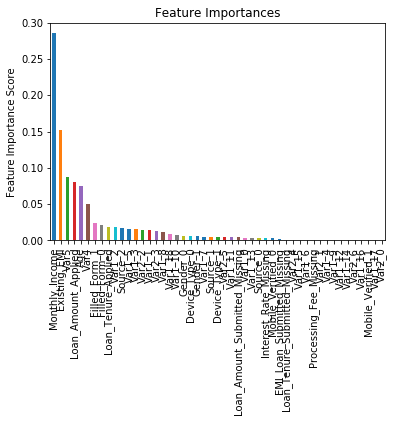

In [32]:
features = [x for x in train.columns if x not in [target, id_col]]
gbm0 = GradientBoostingClassifier(random_state=10)
model_fit(gbm0, train, features)

In [ ]:
print(features)